In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchio as tio

from glio.data.DS import DSToTarget
from glio.datasets import LUMIERE
from glio import nn as gnn
from glio.nn import conv, convt, linear
from glio.torch_tools import summary, lr_finder
from glio.jupyter_tools import clean_mem, show_slices, show_slices_arr
from glio.loaders import nifti
from glio.train import *
from glio.points import Point, BoundingBox, draw_point, draw_bbox, bbox_from_xxdd as xxdd

In [2]:
lum = LUMIERE.LUMIERE()
print(lum.col_names())

['Patient', 'Survival time (weeks)', 'Sex', 'Age at surgery (years)', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative', 'MGMT quantitative', 'Date', 'LessThan3Months', 'NonMeasurableLesions', 'RANO', 'bbox', 'CT1 image', 'CT1 mask', 'CT1 necrosis bbox', 'CT1 hga-image', 'CT1 hga-mask', 'CT1 hga-non-enhancing bbox', 'CT1 hga-contrast-enhancing bbox', 'T1 hga-image', 'T1 hga-mask', 'T1 hga-non-enhancing bbox', 'T1 hga-contrast-enhancing bbox', 'T2 hga-image', 'T2 hga-mask', 'T2 hga-non-enhancing bbox', 'T2 hga-contrast-enhancing bbox', 'FLAIR hga-image', 'FLAIR hga-mask', 'FLAIR hga-non-enhancing bbox', 'FLAIR hga-contrast-enhancing bbox', 'CT1 contrast-enhancing bbox', 'CT1 edema bbox', 'T1 image', 'T1 mask', 'T1 necrosis bbox', 'T1 contrast-enhancing bbox', 'T1 edema bbox', 'T2 image', 'T2 mask', 'T2 necrosis bbox', 'T2 contrast-enhancing bbox', 'T2 edema bbox', 'FLAIR image', 'FLAIR mask', 'FLAIR necrosis bbox', 'FLAIR contrast-enhancing bbox', 'FLAIR edema bbox']


## Загрузчик
Загрузчик возращает `[T1, Mask, BBox]`.

Чёрную область вокруг изображения можно удалить `[25:-25,25:-35,20:-20]`.

Получаем `132, 158, 142`

Трансформация берёт каждый 9 саггитальный срез, получаем 16 срезов из 142. Можно потом попробовать воспользоваться изменением размера.


### mean / std
- T1 image - `3567939758e+01`; `161.2564239502`
- FLAIR image - `5.9002014160e+01`; `129.0489959717`
- T1 mask - `2.4059068412e-02`; `0.2359057516`


In [3]:
slices = [slice(25,-25),slice(25,-35),slice(20,-20)]
ch_slices = [slice(None), *slices]
d = lum.get_cols(["T1 image", "T1 mask", "T1 contrast-enhancing bbox"])

mean_std = (7.3567939758e+01, 0), (161.2564239502, 1)
def normalize(x:torch.Tensor):
    return (x - x.mean()) / x.std()


def loader(x: dict):
    img3d = torch.stack(((nifti.read(x["T1 image"])), nifti.read(x["T1 mask"])))[:,*slices].permute(0,3,2,1)
    shape = img3d.shape
    img3d = img3d[:, ::9]
    img3d[0] = normalize(img3d[0])
    mask = F.one_hot(img3d[1].to(torch.int64)).permute(3, 0, 1, 2)
    return img3d[0], mask, xxdd(x["T1 contrast-enhancing bbox"], arr=shape).crop(slices).permute(2,1,0).translate(img3d).center()
    #bbox = x["T1 contrast-enhancing bbox"]

sample_idx = 1
sample_img, sample_mask, sample_bbox = loader(d[sample_idx])
print(f"{sample_img.shape = }, {sample_mask.shape = }")
print(f"{sample_img.min() = }, {sample_img.max() = }, {sample_img.mean() = }, {sample_img.std() = }")#type:ignore
print(f"{sample_mask.min() = }, {sample_mask.max() = }, {sample_mask.dtype = }")#type:ignore
print(sample_bbox)
show_slices_arr(sample_bbox.draw(loader(d[sample_idx])[0]))

sample_img.shape = torch.Size([16, 158, 132]), sample_mask.shape = torch.Size([4, 16, 158, 132])
sample_img.min() = tensor(-0.8344), sample_img.max() = tensor(4.5332), sample_img.mean() = tensor(2.8153e-06), sample_img.std() = tensor(1.)
sample_mask.min() = tensor(0), sample_mask.max() = tensor(1), sample_mask.dtype = torch.int64
Absolute point(10.816901408450704, 41.0, 45.0)


interactive(children=(Checkbox(value=False, description='color'), Text(value='0 1 2 3', description='permute')…

<function glio.jupyter_tools.show_slices_arr.<locals>.f(color, permute: str, **kwargs)>

In [4]:
show_slices_arr(sample_mask.to(torch.float32))

interactive(children=(Checkbox(value=False, description='color'), Text(value='0 1 2 3', description='permute')…

<function glio.jupyter_tools.show_slices_arr.<locals>.f(color, permute: str, **kwargs)>

In [5]:
def transform_init(x: tuple[torch.Tensor,torch.Tensor, Point]): return x
def transform_sample(x: tuple[torch.Tensor,torch.Tensor, Point]):
    return x[0]
def transform_target(x: tuple[torch.Tensor,torch.Tensor, Point]):
    return x[1], x[2].to_rel().coords

ds = DSToTarget()
ds.add_samples(d, loader, transform_init, transform_sample, transform_target)
print(len(ds))
ds_train, ds_test = ds.split(0.85)
mean_std = ds_train.get_mean_std(16, 8)
print(len(ds_train), len(ds_test))
mean_std

572
0 / 2: mean = tensor([-0.9202, -0.7505, -0.4647, -0.1434,  0.2295,  0.5027,  0.6881,  0.7481,
         0.7035,  0.6615,  0.5376,  0.2822, -0.0382, -0.3732, -0.7381, -0.9249]), std = tensor([0.1698, 0.5518, 0.8167, 0.9423, 0.9179, 0.8689, 0.8427, 0.8359, 0.8446,
1 / 2: mean = tensor([-0.8723, -0.6789, -0.4480, -0.1497,  0.1904,  0.4548,  0.6381,  0.7187,
         0.6781,  0.6351,  0.5281,  0.2944, -0.0133, -0.3455, -0.7083, -0.9215]), std = tensor([0.2775, 0.6266, 0.8339, 0.9462, 0.9413, 0.9066, 0.8671, 0.8526, 0.8520,
        0.8981, 0.9430, 0.9799, 0.9661, 0.8621, 0.5712, 0.1252])
486 86


(tensor([-0.8723, -0.6789, -0.4480, -0.1497,  0.1904,  0.4548,  0.6381,  0.7187,
          0.6781,  0.6351,  0.5281,  0.2944, -0.0133, -0.3455, -0.7083, -0.9215]),
 tensor([0.2775, 0.6266, 0.8339, 0.9462, 0.9413, 0.9066, 0.8671, 0.8526, 0.8520,
         0.8981, 0.9430, 0.9799, 0.9661, 0.8621, 0.5712, 0.1252]))

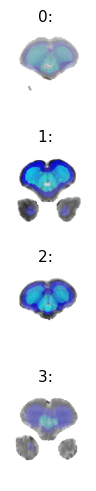

In [6]:
ds.preview(4)

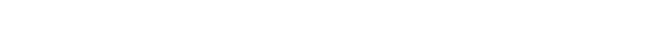

(torch.Size([8, 16, 158, 132]),
 torch.Size([8, 4, 16, 158, 132]),
 tensor(5.6072e-08),
 tensor(1.0000))

In [7]:
from glio.visualize import vis_imshow_grid
batch = next(iter(DataLoader(ds, batch_size=8)))
vis_imshow_grid(batch[0][0])
batch[0].shape, batch[1][0].shape, batch[0].mean(), batch[0].std()

In [8]:
batch[1][0].shape

torch.Size([8, 4, 16, 158, 132])

## Модель

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import ops

from glio import nn as gnn
from glio.nn import conv, convt, linear
from glio.torch_tools import summary, lr_finder
from glio.train import *

In [12]:
class CNN_Base_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_Base_bbox(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_Base_bbox/conv1/0               torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_Base_bbox/conv1/1               torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_Base_bbox/conv1/2               torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_Base_bbox/conv2/0               torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_Base_bbox/conv2/1               torch.nn.modules.activation.GELU             (8, 32, 38, 32)          (8, 32, 38, 32)          0         0         
__main__.CNN_Base_bbox/conv2/2    

In [11]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_Base_bbox()
opt = optim.AdamW(model.parameters())
#lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=2)
1

1

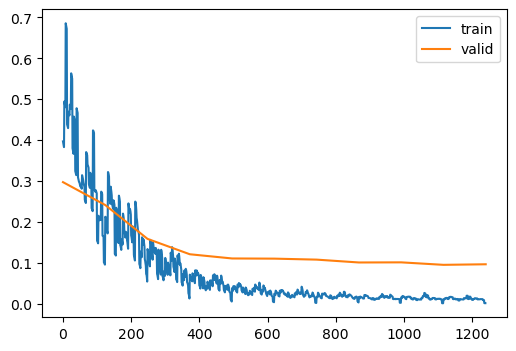

In [12]:
clean_mem()
lr = 5e-5
batch_size = 16
cache_elems = 4
n_epochs = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, batch_size), cache_elems)
dl_test = DataLoader(ds_test, batch_size)
model = CNN_Base_bbox()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)

learner = Learner(model, "LUMIERE1 CNNBase",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Log_SignalHistorgram(64)],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)

learner.logger.last("test loss") = 0.09611319998900096


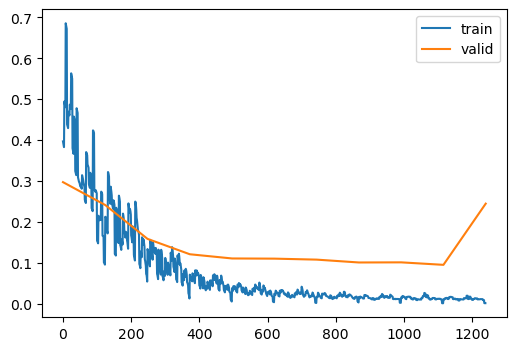

l1: learner.logger.last("test loss") = 0.24447754522164664


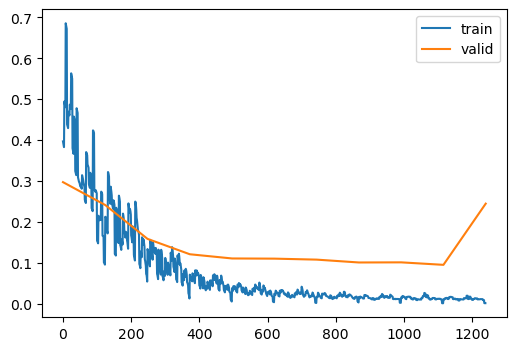

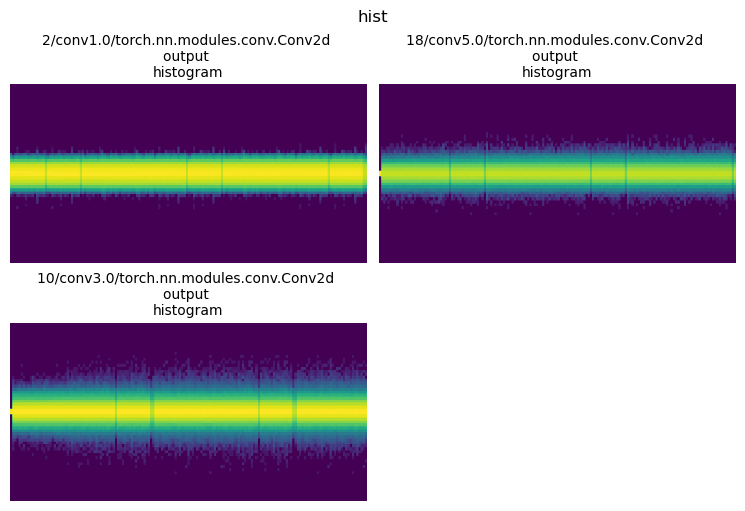

TypeError: expected Tensor as element 0 in argument 0, but got list

In [14]:
from glio.train.cbs_log import Log_Preds, Log_PredsSep, Write_Preds
print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()])
print(f'l1: {learner.logger.last("test loss") = }')
learner.logger.hist_all("hist")
learner.logger.save("LUMIERE1 CNNBase logger.npz")

In [13]:
class CNN_Dropout_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.65, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_Dropout_bbox(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_Dropout_bbox/conv1/0            torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_Dropout_bbox/conv1/1            torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_Dropout_bbox/conv1/2            torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_Dropout_bbox/conv1/3            torch.nn.modules.dropout.Dropout2d           (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_Dropout_bbox/conv2/0            torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_Dropout_bbox/conv2/1 

Iteration 9 done.0002e-06 loss: 2.16568326950073247


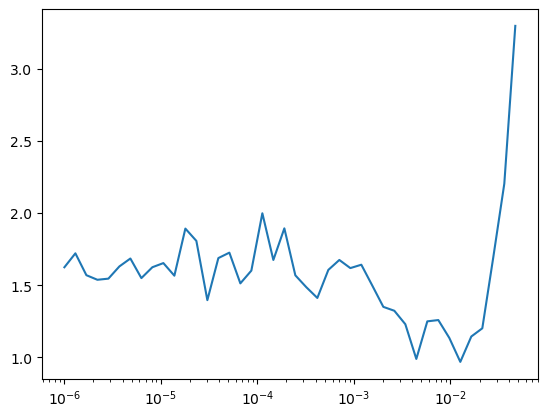

1

In [16]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_Dropout_bbox()
opt = optim.AdamW(model.parameters())
lrs,losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=10)
1

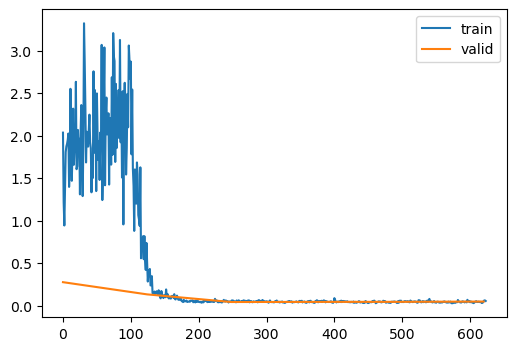

Keyboard interrupt, stopping the training...


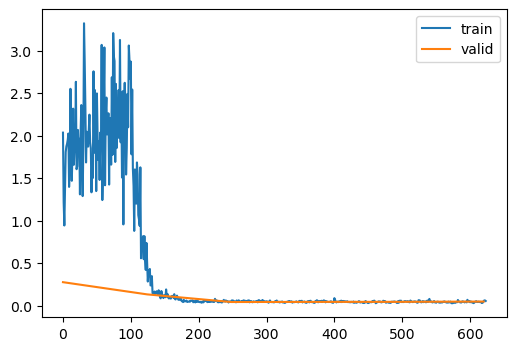

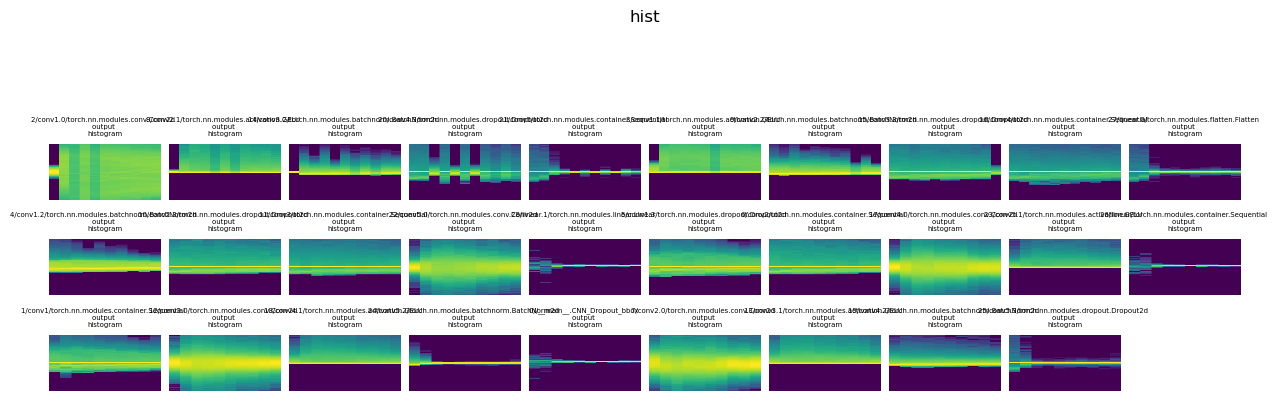

learner.logger.last("train loss") = 0.05587853491306305


In [14]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))

import matplotlib.pyplot as plt
clean_mem()
lr = 9e-2
batch_size = 16
cache_elems = 4
n_epochs = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, batch_size), cache_elems)
dl_test = DataLoader(ds_test, batch_size)
model = CNN_Dropout_bbox()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)

learner = Learner(model, "LUMIERE1 CNNBase",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Log_SignalHistorgram(4), Log_Preds()],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)
plt.show()
learner.logger.hist_all("hist")
print(f'{learner.logger.last("train loss") = }')

learner.logger.last("test loss") = 0.049236744021375976


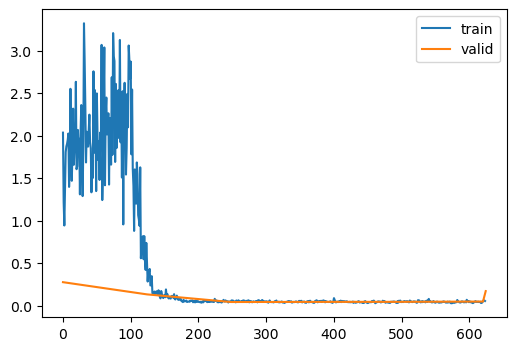

l1: learner.logger.last("test loss") = 0.17217074086268744


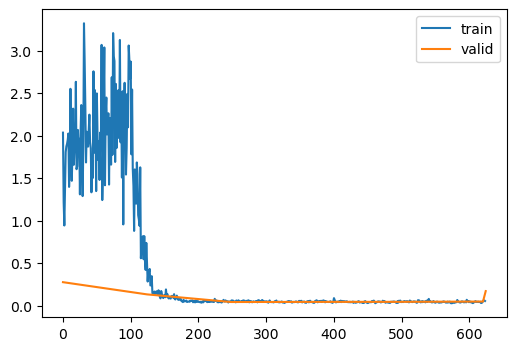

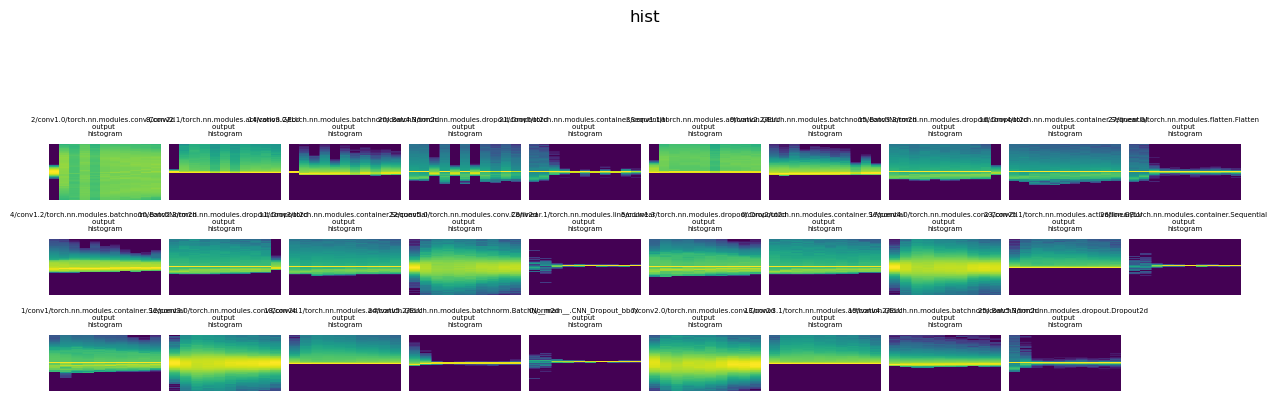

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (7, 2) + inhomogeneous part.

In [15]:
print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()])
print(f'l1: {learner.logger.last("test loss") = }')
learner.logger.hist_all("hist")
learner.logger.save("LUMIERE1 bbox CNN Base + Dropout logger.npz")

In [13]:
class CNN_NiN_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.65, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.nin = conv(64, 3, 1, act=nn.GELU(), pool=nn.AvgPool2d(4, 1))
        self.flatten = nn.Flatten()
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.flatten(self.nin(x))

summary(CNN_NiN_bbox(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_NiN_bbox/conv1/0                torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_NiN_bbox/conv1/1                torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_NiN_bbox/conv1/2                torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_NiN_bbox/conv1/3                torch.nn.modules.dropout.Dropout2d           (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_NiN_bbox/conv2/0                torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_NiN_bbox/conv2/1     

Iteration 9 done.539266 loss: 0.28227430582046517686


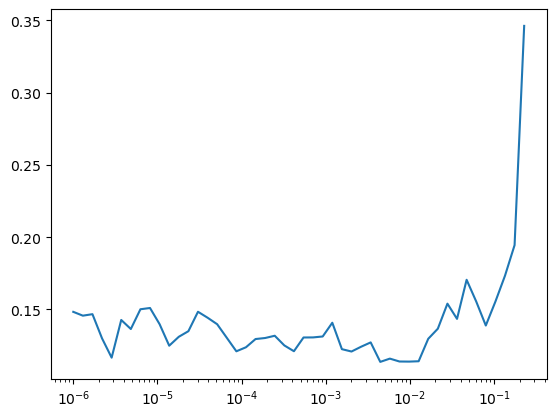

1

In [ ]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_NiN_bbox()
opt = optim.AdamW(model.parameters())
lrs,losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=10)
1

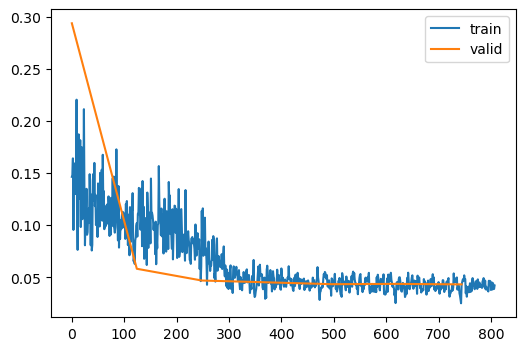

Keyboard interrupt, stopping the training...


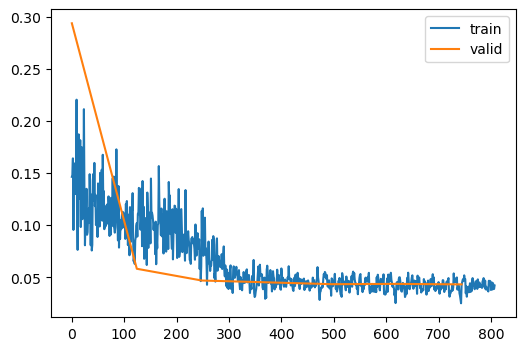

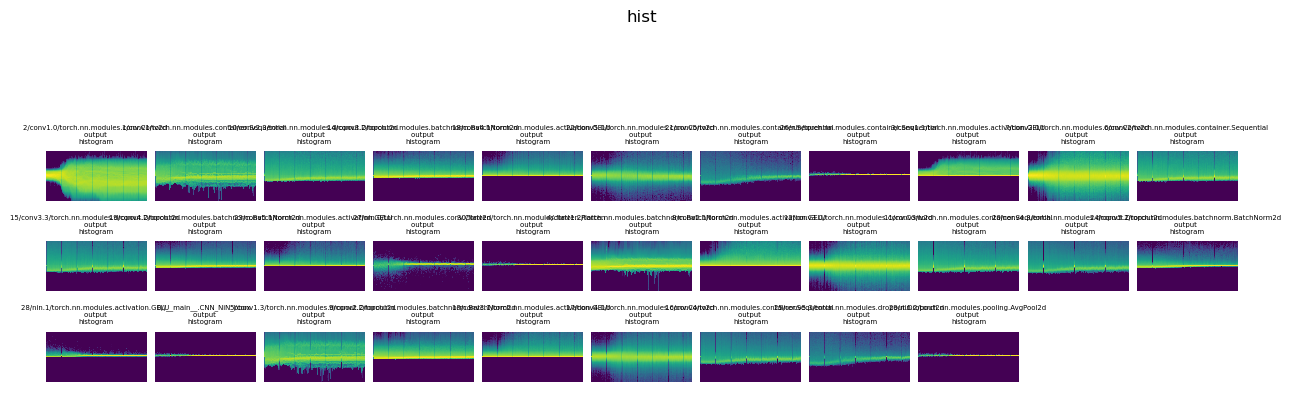

learner.logger.last("train loss") = 0.042121924459934235
learner.logger.last("test loss") = 0.043197873358925186
l1: learner.logger.last("test loss") = 0.17717680831750235


In [14]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))

import matplotlib.pyplot as plt
clean_mem()
lr = 9e-3
batch_size = 16
cache_elems = 4
n_epochs = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, batch_size), cache_elems)
dl_test = DataLoader(ds_test, batch_size)
model = CNN_NiN_bbox()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)

learner = Learner(model, "LUMIERE1 CNNBase",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Log_SignalHistorgram(4), Log_Preds()],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)
plt.show()
learner.logger.hist_all("hist")
print(f'{learner.logger.last("train loss") = }')

print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()], ["FastProgressBar"])
print(f'l1: {learner.logger.last("test loss") = }')

In [11]:
class CNN_LMConv_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.65, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.lmconv = nn.Sequential(gnn.ChannelConcat(gnn.LMConv((16,16), 64),gnn.LMConv((16,16), 64),gnn.LMConv((16,16), 64)), nn.GELU(), nn.AvgPool2d(13, 1))
        self.flatten = nn.Flatten()
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.flatten(self.lmconv(x))

summary(CNN_LMConv_bbox(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_LMConv_bbox/conv1/0             torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_LMConv_bbox/conv1/1             torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_LMConv_bbox/conv1/2             torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_LMConv_bbox/conv1/3             torch.nn.modules.dropout.Dropout2d           (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_LMConv_bbox/conv2/0             torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_LMConv_bbox/conv2/1  

Iteration 9 done.4114308 loss: 0.2622882723808288632


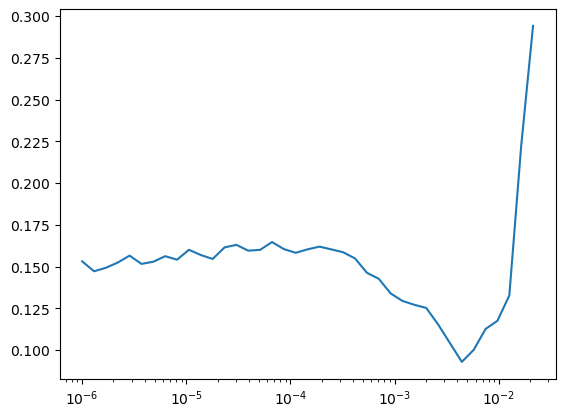

1

In [14]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_LMConv_bbox()
opt = optim.AdamW(model.parameters())
lrs,losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=10)
1

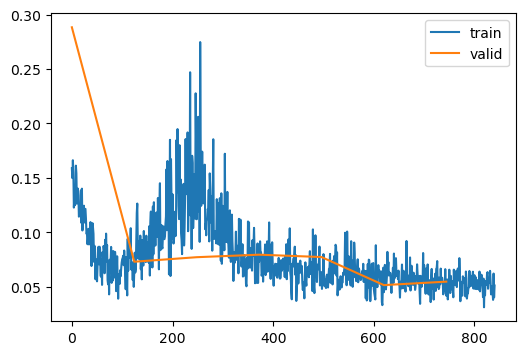

MemoryError: 

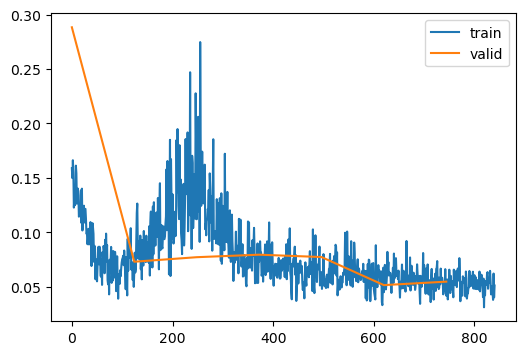

In [12]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))

import matplotlib.pyplot as plt
clean_mem()
lr = 8e-3
batch_size = 16
cache_elems = 4
n_epochs = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, batch_size), cache_elems)
dl_test = DataLoader(ds_test, batch_size)
model = CNN_LMConv_bbox()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)

learner = Learner(model, "LUMIERE1 CNNBase",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Log_SignalHistorgram(4), Log_Preds()],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)
plt.show()
learner.logger.hist_all("hist")
print(f'{learner.logger.last("train loss") = }')

print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()], ["FastProgressBar"])
print(f'l1: {learner.logger.last("test loss") = }')

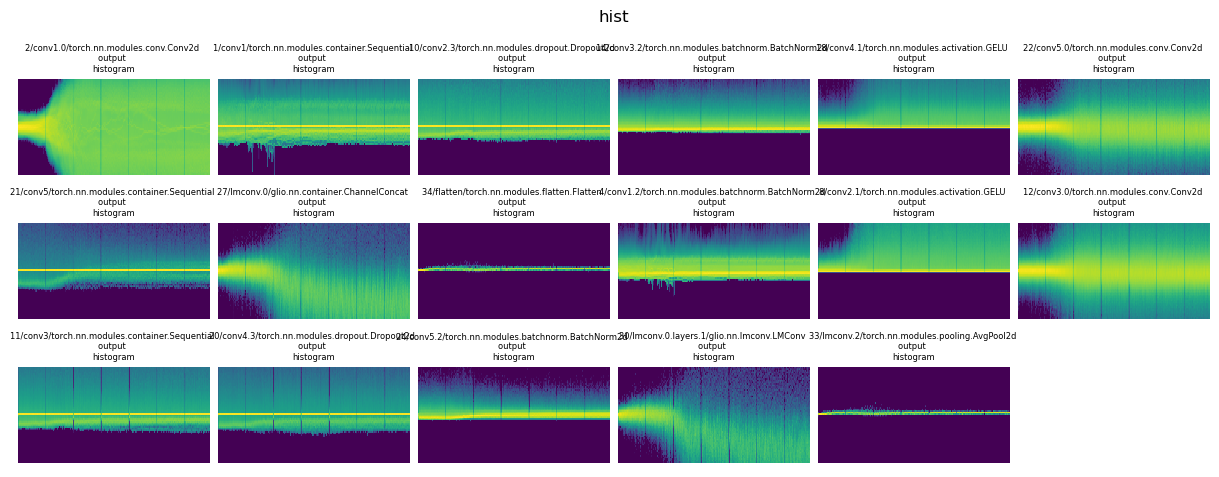

learner.logger.last("train loss") = 0.05128335580229759
learner.logger.last("test loss") = 0.05461709573864937


MemoryError: Unable to allocate output buffer.

In [13]:
learner.logger.hist_all("hist")
print(f'{learner.logger.last("train loss") = }')

print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()], ["FastProgressBar"])
print(f'l1: {learner.logger.last("test loss") = }')